<a href="https://colab.research.google.com/github/owoMarciN/Python/blob/main/Intro-AI/Lab-III/AI_Parkinson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!pip install torch
!pip install lion-pytorch
!pip install torchvision
!pip install --upgrade ucimlrepo
!pip install optuna

In [2]:
from ucimlrepo import fetch_ucirepo, list_available_datasets

# check which datasets can be imported
#list_available_datasets()

# import dataset
park = fetch_ucirepo(id=174)

# access data
X = park.data.features
y = park.data.targets
# train model e.g. sklearn.linear_model.LinearRegression().fit(X, y)

# access metadata
# print(park.metadata.uci_id)
# print(park.metadata.num_instances)
# print(park.metadata.additional_info.summary)

# access variable info in tabular format
# print(park.variables)

In [31]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch_optimizer as toptim

In [4]:
# SciKit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
# Ploting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
# Checking the data

#print(X.describe())
feature_names = X.columns.values

#-------------------------------------------------------------------------------
##[PLOT] Creating a **Countplot** of the dataset features.
#-------------------------------------------------------------------------------

In [ ]:
# Class distribution plot

sns.countplot(x=y['status'])
plt.title("Class distribution")
plt.xlabel("Classes (0 - Healthy, 1 - Parkinson)")
plt.ylabel("Count")
plt.show()

#-------------------------------------------------------------------------------
##[PLOT] Creating a **Pairplot** of the dataset.
#-------------------------------------------------------------------------------

In [ ]:
pp_data = X[['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:RAP', 'MDVP:PPQ']]

sns.pairplot(pp_data)
plt.show()

#-------------------------------------------------------------------------------
##[PLOT] Creating a **Correlation HeatMap** of the dataset.
#-------------------------------------------------------------------------------

In [ ]:
if isinstance(y, pd.DataFrame):
    df = pd.concat([X, y], axis=1)
else:
    df = X.copy()
    df["target"] = y

# --- 2. Compute correlation matrix ---
corr = df.corr(method="pearson")  # or "spearman"

# --- 3. Plot heatmap ---
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.3,
    square=True
)

plt.title("Correlation Heatmap – UCI Parkinson Dataset (ID=174)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
import time

class MLP(nn.Module):
    def __init__(self, in_dim=30, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def get_optimizer(name, params, lr, momentum=0.9):
    name = name.lower()
    if name == "sgd":
        return optim.SGD(params, lr=lr)
    if name == "momentum":
        return optim.SGD(params, lr=lr, momentum=momentum)
    if name == "adam":
        return optim.Adam(params, lr=lr)
    if name == "rmsprop":
        return optim.RMSprop(params, lr=lr, momentum=momentum)
    raise ValueError("Unknown optimizer")

In [8]:
def train_and_eval(opt_name, lr, epochs, momentum, Xtr, Xte, ytr, yte, in_dim=30):
    start_time = time.time()
    model = MLP(in_dim=in_dim)
    optimizer = get_optimizer(opt_name, model.parameters(), lr, momentum)
    criterion = nn.BCELoss()
    losses = []

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = criterion(outputs, ytr)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return losses, {
            "acc": accuracy_score(yte, y_pred),
            "prec": precision_score(yte, y_pred),
            "rec": recall_score(yte, y_pred),
            "f1": f1_score(yte, y_pred),
            "auc": roc_auc_score(yte, y_prob)
    }, elapsed_time

In [9]:
X = StandardScaler().fit_transform(X).astype('float32')
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

Xtr, Xte = map(torch.tensor, (Xtr, Xte))
ytr, yte = map (lambda v : torch.tensor(v.values).float(), (ytr, yte))

In [ ]:
losses, metrics, elapsed_time = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
print(f"Baseline metrics (opt_name=Adam)\n {metrics}")
print(f"Elapsed time: {elapsed_time:.4f} seconds")

#-------------------------------------------------------------------------------
##[PLOT] Creating a **Boxplot** of the normalized data of the dataset.
#-------------------------------------------------------------------------------

In [ ]:
plt.figure(figsize=(14, 8))

sns.boxplot(data=X)

plt.xticks(
    ticks=range(len(feature_names)),
    labels=feature_names,
    rotation=90,
)

plt.xlabel("Features")
plt.ylabel("Normalized Value")

plt.title("Boxplots for All Features – UCI Parkinson Dataset")
plt.tight_layout()
plt.show()

In [ ]:
# baseline MLP
opt = ["adam", "sgd", "momentum", "rmsprop"]
losses_all = []
f1_all = []
acc_all = []
epochs = []
elapsed_times = []

for opt_name in opt:
    losses, metrics, elapsed_time = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
    f1_all.append(metrics["f1"])
    acc_all.append(metrics["acc"])
    losses_all.append(losses)
    elapsed_times.append(elapsed_time)

for i, opt_name in enumerate(opt):
    plt.plot(losses_all[i], label=opt_name)
plt.legend()
plt.savefig("lossfun.png")
plt.show()

for i, opt_name in enumerate(opt):
    print(f"{opt_name:10s}  acc={acc_all[i]:.4f}  f1={f1_all[i]:.4f}  time={elapsed_times[i]:.4f}s")

In [ ]:
def train_and_eval(opt_name, lr, epochs, momentum, Xtr, Xte, ytr, yte, in_dim=30):
    start_time = time.time()
    model = MLP(in_dim=in_dim)
    optimizer = get_optimizer(opt_name, model.parameters(), lr, momentum)
    criterion = nn.BCELoss()
    losses = []
    f1_scores = []

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = criterion(outputs, ytr)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        model.eval()
        with torch.no_grad():
            y_prob = model(Xte).numpy()
        y_pred = (y_prob >= 0.5).astype(int)
        f1_scores.append(f1_score(yte, y_pred))

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return losses, {
            "acc": accuracy_score(yte, y_pred),
            "prec": precision_score(yte, y_pred),
            "rec": recall_score(yte, y_pred),
            "f1": f1_score(yte, y_pred),
            "auc": roc_auc_score(yte, y_prob)
    }, elapsed_time, f1_scores

In [ ]:
# baseline MLP
opt = ["adam", "sgd", "momentum", "rmsprop"]
losses_all = []
f1_all = []
acc_all = []
epochs = []
elapsed_times = []

for opt_name in opt:
    losses, metrics, elapsed_time, f1_scores = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
    f1_all.append(f1_scores)

for i, opt_name in enumerate(opt):
    plt.plot(f1_all[i], label=opt_name)
plt.legend()
plt.show()

In [ ]:
from torch.optim.lr_scheduler import StepLR

def train_and_eval(opt_name, lr, epochs, momentum, Xtr, Xte, ytr, yte, in_dim=30):
    start_time = time.time()
    model = MLP(in_dim=in_dim)
    optimizer = get_optimizer(opt_name, model.parameters(), lr, momentum)
    criterion = nn.BCELoss()
    losses = []
    l_rates = []

    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = criterion(outputs, ytr)
        loss.backward()

        losses.append(loss.item())
        l_rates.append(scheduler.get_last_lr())

        optimizer.step()
        scheduler.step()

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return losses, {
            "acc": accuracy_score(yte, y_pred),
            "prec": precision_score(yte, y_pred),
            "rec": recall_score(yte, y_pred),
            "f1": f1_score(yte, y_pred),
            "auc": roc_auc_score(yte, y_prob)
    }, elapsed_time, l_rates

In [ ]:
# baseline MLP
opt = ["adam", "sgd", "momentum", "rmsprop"]
losses_all = []
f1_all = []
acc_all = []
epochs = []
elapsed_times = []
lr_all = []

for opt_name in opt:
    losses, metrics, elapsed_time, l_rates = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
    f1_all.append(metrics["f1"])
    acc_all.append(metrics["acc"])
    losses_all.append(losses)
    lr_all.append(l_rates)
    elapsed_times.append(elapsed_time)

for i, opt_name in enumerate(opt):
    plt.plot(losses_all[i], label=opt_name)
plt.legend()
plt.show()

for i, opt_name in enumerate(opt):
    print(f"{opt_name:10s}  acc={acc_all[i]:.4f}  f1={f1_all[i]:.4f}  time={elapsed_times[i]:.4f}s")


for i, opt_name in enumerate(opt):
    plt.plot(lr_all[i])
plt.show()

In [10]:
def kmeans_features(X_train, X_test, n_clusters=8, random_state=42):
    # Ensure inputs are NumPy arrays for KMeans and subsequent NumPy operations
    if isinstance(X_train, torch.Tensor):
        X_train_np = X_train.numpy()
    else:
        X_train_np = X_train

    if isinstance(X_test, torch.Tensor):
        X_test_np = X_test.numpy()
    else:
        X_test_np = X_test

    kmeans = KMeans(n_clusters=n_clusters,
    n_init=10,
    random_state=random_state)
    kmeans.fit(X_train_np)

    def to_dist(X_arr):
        # X_arr will already be a NumPy array if the outer conversion happened
        return np.linalg.norm(
            X_arr[:, None, :] - kmeans.cluster_centers_[None, :, :],
            axis=2
            ).astype("float32")

    return to_dist(X_train_np), to_dist(X_test_np)

In [11]:
Xtr_km, Xte_km = kmeans_features(Xtr, Xte, n_clusters=8)

Xtr_km = torch.tensor(Xtr_km, dtype=torch.float32)
Xte_km = torch.tensor(Xte_km, dtype=torch.float32)

losses, metrics, elapsed_time, l_rates = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_km, Xte=Xte_km, ytr=ytr, yte=yte, in_dim=8)
metrics

ValueError: not enough values to unpack (expected 4, got 3)

In [12]:
def pca_features(X_train, X_test, var_threshold=0.95, random_state=42):
    # PCA
    pca = PCA(n_components=var_threshold, random_state=random_state)

    pca.fit(X_train)

    # Transformation train/test
    X_train_pca = pca.transform(X_train).astype("float32")
    X_test_pca = pca.transform(X_test).astype("float32")

    # Number of components
    n_components = pca.n_components_

    print(f"We used {n_components} PCA components, to get ≥{int(var_threshold*100)}% variation.")

    return X_train_pca, X_test_pca, n_components

In [ ]:
Xtr_pca, Xte_pca, n_components = pca_features(Xtr, Xte, var_threshold=0.95)

Xtr_pca = torch.tensor(Xtr_pca, dtype=torch.float32)
Xte_pca = torch.tensor(Xte_pca, dtype=torch.float32)

losses, metrics, elapsed_time, l_rates = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_pca, Xte=Xte_pca, ytr=ytr, yte=yte, in_dim=n_components)
metrics

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=30, bottleneck_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

    def encode(self, x):
        """Returns the 8-D bottleneck representation."""
        return self.encoder(x)

In [14]:
def autoencoder_features(X_train, X_test, epochs=50, lr=1e-3):
    input_dim = X_train.shape[1]
    bottleneck_dim = 8

    ae = Autoencoder(input_dim=input_dim, bottleneck_dim=bottleneck_dim)
    optimizer = optim.Adam(ae.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    Xtr_tensor = X_train.float()

    # Training loop
    for _ in range(epochs):
        optimizer.zero_grad()
        recon = ae(Xtr_tensor)
        loss = loss_fn(recon, Xtr_tensor)
        loss.backward()
        optimizer.step()

    # Extract 8-D features
    with torch.no_grad():
        Z_train = ae.encode(X_train.float())
        Z_test  = ae.encode(X_test.float())

    return Z_train, Z_test

In [ ]:
Xtr_ae, Xte_ae = autoencoder_features(Xtr, Xte, epochs=100, lr=1e-3)

losses, metrics, elapsed_time, l_rates = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_ae, Xte=Xte_ae, ytr=ytr, yte=yte, in_dim=8)
metrics

In [ ]:
from sklearn.decomposition import PCA
ytr_np = ytr.numpy().ravel()

# PCA 2D
pca_2d = PCA(n_components=2)
Xtr_pca_2d = pca_2d.fit_transform(Xtr_pca)  # Xtr should be NumPy

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(ytr_np):
    plt.scatter(Xtr_pca_2d[ytr_np == label, 0], Xtr_pca_2d[ytr_np == label, 1], label=f"Class {label}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ytr_np = ytr.numpy().ravel()

# PCA 2D
pca_2d = PCA(n_components=2)
Xtr_ae_2d = pca_2d.fit_transform(Xtr_ae)

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(ytr_np):
    plt.scatter(Xtr_ae_2d[ytr_np == label, 0], Xtr_ae_2d[ytr_np == label, 1], label=f"Class {label}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D AE Projection")
plt.legend()
plt.grid(True)
plt.show()

## Hyper-parameters


In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import itertools
import random
import optuna

from lion_pytorch import Lion
from torch.utils.data import DataLoader, TensorDataset
from optuna.samplers import TPESampler, NSGAIISampler, GridSampler, RandomSampler
from optuna.pruners import HyperbandPruner

In [46]:
search_space = {
    "lr": [1e-4, 1e-3, 1e-2, 1e-1],
    "momentum": [0.7, 0.8, 0.9, 0.99],
    "hidden_size": [8, 16, 32],
    "weight_decay": [0.001, 0.01],
    "batch_size": [16, 32, 64]
}

In [59]:
class MLP(nn.Module):
    def __init__(self, in_dim=30, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def get_optimizer(name, params, lr, momentum=0.9, weight_decay=0.0):
    """Return PyTorch optimizer instance based on name."""
    name = name.lower()
    # SGD variants
    if name == "sgd":
        return optim.SGD(params, lr=lr, weight_decay=weight_decay)
    if name == "momentum":
        return optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Adaptive methods
    if name == "adam":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if name == "amsgrad":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay, amsgrad=True)
    if name == "adagrad":
        return optim.Adagrad(params, lr=lr, weight_decay=weight_decay)
    if name == "adadelta":
        return optim.Adadelta(params, lr=lr, weight_decay=weight_decay)

    # Other advanced optimizers (requires torch_optimizer)
    if name == "nadam":
        return optim.NAdam(params, lr=lr, weight_decay=weight_decay)
    if name == "lion":
        return Lion(params, lr=lr, weight_decay=weight_decay)

    # RMSprop
    if name == "rmsprop":
        return optim.RMSprop(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

    raise ValueError(f"Unknown optimizer: {name}")

def train_and_eval_hparams(opt_name, Xtr, Xte, ytr, yte, hparams):
    start_time = time.time()
    model = MLP(in_dim=Xtr.shape[1], hidden=hparams["hidden_size"])
    optimizer = get_optimizer(opt_name, model.parameters(), lr=hparams["lr"], momentum=hparams["momentum"], weight_decay=hparams["weight_decay"])
    criterion = nn.BCELoss()
    losses = []

    train_loader = DataLoader(
        TensorDataset(Xtr, ytr),
        batch_size=hparams["batch_size"],
        shuffle=True
    )

    best_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 10

    for epoch in range(100):
        model.train()
        batch_losses = []

        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb.float())
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)

        if early_stop_patience is not None:
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= early_stop_patience:
                # Early stoping if there is no change
                break
        epochs_run = epoch + 1

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)

    end_time = time.time()
    elapsed_time = end_time - start_time

    metrics = {
        "acc": accuracy_score(yte, y_pred),
        "prec": precision_score(yte, y_pred, zero_division=0),
        "rec": recall_score(yte, y_pred, zero_division=0),
        "f1": f1_score(yte, y_pred, zero_division=0),
        "auc": roc_auc_score(yte, y_prob),
        "epochs": epochs_run
    }

    return metrics, losses, elapsed_time

In [48]:
def objective(opt_name, Xtr, Xte, ytr, yte, trial):
    hp = {
        "lr": trial.suggest_float("lr", 1e-4, 1e-1, log=True),
        "momentum": trial.suggest_float("momentum", 0.7, 0.99),
        "hidden_size": trial.suggest_categorical("hidden_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64])
    }

    metrics, losses, elapsed_time_val = train_and_eval_hparams(opt_name, Xtr, Xte, ytr, yte, hp)
    trial.set_user_attr("losses", losses)
    trial.set_user_attr("elapsed_time", elapsed_time_val)
    trial.set_user_attr("optimizer", opt_name)
    trial.set_user_attr("metrics", metrics)
    return metrics["f1"]

In [49]:
# Optuna Grid Search
def run_optuna_grid_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=GridSampler(search_space=search_space)
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [51]:
# Optuna Random Search
def run_optuna_random_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=RandomSampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [50]:
# Bayesian Optimization — Build surrogate model of performance.
def run_bayesian_optimization(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler()
    )
    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [52]:
# Hyperband / BOHB — Adaptive resource allocation.
def run_hyperband(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        pruner=HyperbandPruner()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [53]:
# Evolutionary / Metaheuristic Search — GA, PSO, DE for AutoML.
def run_evolutionary(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=NSGAIISampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [26]:
results = {}

# As for now testing the baseline with 'Adam' optimizer
adam_opt = "adam"

# Baselines
grid_hp, grid_f1, grid_traj, grid_perf, grid_loss, grid_met = run_optuna_grid_search(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Grid"] = grid_hp
results["Grid_f1"] = grid_f1
results["Grid_traj"] = grid_traj
results["Grid_perf"] = grid_perf
results["Grid_loss"] = grid_loss
results["Grid_met"] = grid_met

rand_hp, rand_f1, rand_traj, rand_perf, rand_loss, rand_met = run_optuna_random_search(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Random"] = rand_hp
results["Random_f1"] = rand_f1
results["Random_traj"] = rand_traj
results["Random_perf"] = rand_perf
results["Random_loss"] = rand_loss
results["Random_met"] = rand_met

# Advanced methods
bo_hp, bo_f1, bo_traj, bo_perf, bo_loss, bo_met = run_bayesian_optimization(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Bayes"] = bo_hp
results["Bayes_f1"] = bo_f1
results["Bayes_traj"] = bo_traj
results["Bayes_perf"] = bo_perf
results["Bayes_loss"] = bo_loss
results["Bayes_met"] = bo_met

hb_hp, hb_f1, hb_traj, hb_perf, hb_loss, hb_met = run_hyperband(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Hyperband"] = hb_hp
results["Hyperband_f1"] = hb_f1
results["Hyperband_traj"] = hb_traj
results["Hyperband_perf"] = hb_perf
results["Hyperband_loss"] = hb_loss
results["Hyperband_met"] = hb_met

ev_hp, ev_f1, ev_traj, ev_perf, ev_loss, ev_met = run_evolutionary(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Evolutionary"] = ev_hp
results["Evolutionary_f1"] = ev_f1
results["Evolutionary_traj"] = ev_traj
results["Evolutionary_perf"] = ev_perf
results["Evolutionary_loss"] = ev_loss
results["Evolutionary_met"] = ev_met

[I 2025-12-07 11:59:42,315] A new study created in memory with name: no-name-845b3187-3b62-4871-a9ad-e37d80963129
[I 2025-12-07 11:59:42,674] Trial 0 finished with value: 1.0 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 16, 'weight_decay': 0.01, 'batch_size': 16}. Best is trial 0 with value: 1.0.
[I 2025-12-07 11:59:43,417] Trial 1 finished with value: 0.9824561403508771 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 32}. Best is trial 0 with value: 1.0.
[I 2025-12-07 11:59:43,708] Trial 2 finished with value: 0.9824561403508771 and parameters: {'lr': 0.1, 'momentum': 0.9, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 16}. Best is trial 0 with value: 1.0.
[I 2025-12-07 11:59:43,857] Trial 3 finished with value: 0.9655172413793104 and parameters: {'lr': 0.01, 'momentum': 0.7, 'hidden_size': 8, 'weight_decay': 0.001, 'batch_size': 64}. Best is trial 0 with value: 1.0.
[I 2025-12-07 11:59:44,316] Trial 4 fi

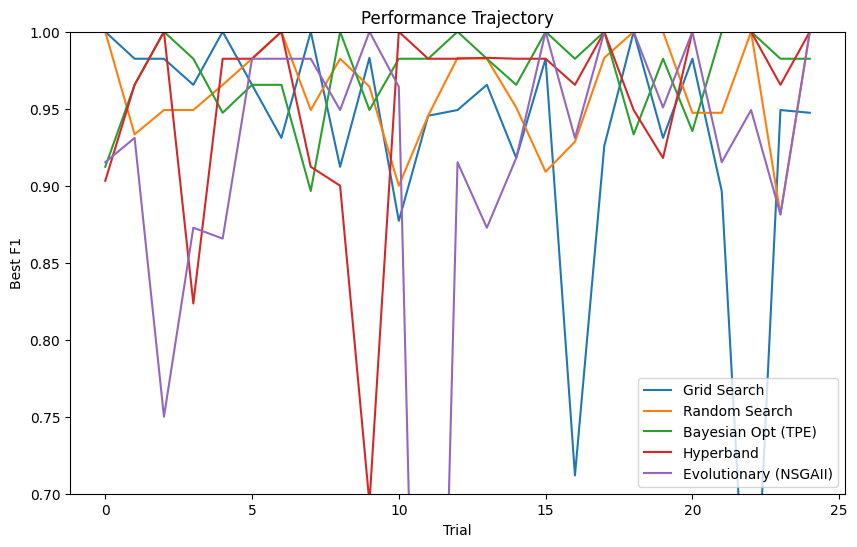

In [35]:
# ------------------------------------------------------------------------------
# Truncate trajectories and performances for consistent plotting, as Optuna
# Grid Search runs all combinations while other methods are limited by
# n_trials (defaulting to 25).
# ------------------------------------------------------------------------------

N_TRIALS = 25

plt.figure(figsize=(10, 6))
plt.plot(results["Grid_traj"][:N_TRIALS], label="Grid Search")
plt.plot(results["Random_traj"][:N_TRIALS], label="Random Search")
plt.plot(results["Bayes_traj"][:N_TRIALS], label="Bayesian Opt (TPE)")
plt.plot(results["Hyperband_traj"][:N_TRIALS], label="Hyperband")
plt.plot(results["Evolutionary_traj"][:N_TRIALS], label="Evolutionary (NSGAII)")

plt.ylim([0.7, 1.0])
plt.xlabel("Trial")
plt.ylabel("Best F1")
plt.title("Performance Trajectory")
plt.legend()
plt.show()

# ------------------------------------------------------------------------------
# Changes to the evaluation class must be made if you want the 'elapsed_time'
# trajectories.
# For now 'grid_perf' returns only the best trial performance time.
# ------------------------------------------------------------------------------

# plt.figure(figsize=(10, 6))
# plt.plot(results["Grid_perf"][:N_TRIALS], label="Grid Search")
# plt.plot(results["Random_perf"][:N_TRIALS], label="Random Search")
# plt.plot(results["Bayes_perf"][:N_TRIALS], label="Bayesian Opt (TPE)")
# plt.plot(results["Hyperband_perf"][:N_TRIALS], label="Hyperband")
# plt.plot(results["Evolutionary_perf"][:N_TRIALS], label="Evolutionary (NSGAII)")

# plt.xlabel("Trial")
# plt.ylabel("Elapsed Time (s)")
# plt.title("Elapsed Time per Trial")
# plt.legend()
# plt.show()

In [28]:
table = pd.DataFrame({
    "Method": ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"],
    "Best F1": [results["Grid_met"]["f1"], results["Random_met"]["f1"], results["Bayes_met"]["f1"], results["Hyperband_met"]["f1"], results["Evolutionary_met"]["f1"]],
    "Accuracy": [results["Grid_met"]["acc"], results["Random_met"]["acc"], results["Bayes_met"]["acc"], results["Hyperband_met"]["acc"], results["Evolutionary_met"]["acc"]],
    "Precision": [results["Grid_met"]["prec"], results["Random_met"]["prec"], results["Bayes_met"]["prec"], results["Hyperband_met"]["prec"], results["Evolutionary_met"]["prec"]],
    "Recall": [results["Grid_met"]["rec"], results["Random_met"]["rec"], results["Bayes_met"]["rec"], results["Hyperband_met"]["rec"], results["Evolutionary_met"]["rec"]],
    "AUC": [results["Grid_met"]["auc"], results["Random_met"]["auc"], results["Bayes_met"]["auc"], results["Hyperband_met"]["auc"], results["Evolutionary_met"]["auc"]],
    "Epochs":  [results["Grid_met"]["epochs"], results["Random_met"]["epochs"], results["Bayes_met"]["epochs"], results["Hyperband_met"]["epochs"], results["Evolutionary_met"]["epochs"]],
    "Ran-Time": [results["Grid_perf"], results["Random_perf"], results["Bayes_perf"], results["Hyperband_perf"], results["Evolutionary_perf"]],
    "Best Params": [
        results["Grid"], results["Random"], results["Bayes"], results["Hyperband"], results["Evolutionary"]
    ]

})

print(table)
table.to_latex(index=False)

         Method  Best F1  Accuracy  Precision  Recall  AUC  Epochs  Ran-Time  \
0          Grid      1.0       1.0        1.0     1.0  1.0      26  0.345097   
1        Random      1.0       1.0        1.0     1.0  1.0      99  1.329550   
2         Bayes      1.0       1.0        1.0     1.0  1.0      37  0.195783   
3     Hyperband      1.0       1.0        1.0     1.0  1.0      99  1.280563   
4  Evolutionary      1.0       1.0        1.0     1.0  1.0      99  1.272675   

                                         Best Params  
0  {'lr': 0.01, 'momentum': 0.99, 'hidden_size': ...  
1  {'lr': 0.0032300243907605842, 'momentum': 0.96...  
2  {'lr': 0.06962526793366693, 'momentum': 0.9733...  
3  {'lr': 0.001872991021392007, 'momentum': 0.901...  
4  {'lr': 0.04766883692596765, 'momentum': 0.9365...  


"\\begin{tabular}{lrrrrrrrl}\n\\toprule\nMethod & Best F1 & Accuracy & Precision & Recall & AUC & Epochs & Ran-Time & Best Params \\\\\n\\midrule\nGrid & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 26 & 0.345097 & {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 16, 'weight_decay': 0.01, 'batch_size': 16} \\\\\nRandom & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 99 & 1.329550 & {'lr': 0.0032300243907605842, 'momentum': 0.967663302800077, 'hidden_size': 16, 'weight_decay': 1.3187811425492866e-06, 'batch_size': 16} \\\\\nBayes & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 37 & 0.195783 & {'lr': 0.06962526793366693, 'momentum': 0.9733381828034112, 'hidden_size': 32, 'weight_decay': 0.0022033549709307423, 'batch_size': 64} \\\\\nHyperband & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 99 & 1.280563 & {'lr': 0.001872991021392007, 'momentum': 0.9018849199506973, 'hidden_size': 32, 'weight_decay': 7.364848559265655e-05, 'batch_size': 16} \\\\\nEvolutio

## Everything together - Optimizers $\times$ Reduction Techniques $\times$ Hyper-parameters



In [ ]:
results = {}

opt = [
    "sgd",
    "momentum",
    "adam",
    "amsgrad",
    "adagrad",
    "adadelta",
    "nadam",
    "lion",
    "rmsprop"
]

features = {
    "raw": (Xtr, Xte),
    "kmeans": kmeans_features(Xtr, Xte, n_clusters=8),
    "pca": pca_features(Xtr, Xte, var_threshold=0.95)[:2],
    "autoencoder": autoencoder_features(Xtr, Xte, epochs=100, lr=1e-2)
}

# Convert all to tensors
for key, (Xtr_feat, Xte_feat) in features.items():
    features[key] = (torch.tensor(Xtr_feat, dtype=torch.float32),
                     torch.tensor(Xte_feat, dtype=torch.float32))

for feat_name, (Xtr_feat, Xte_feat) in features.items():
    results[feat_name] = {}

    for opt_name in opt:
        results[feat_name][opt_name] = {}  # Create sub-dict for each optimizer

        # Baselines
        grid_hp, grid_f1, grid_traj, grid_perf, grid_loss, grid_met = run_optuna_grid_search(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Grid"] = grid_hp
        results[feat_name][opt_name]["Grid_f1"] = grid_f1
        results[feat_name][opt_name]["Grid_traj"] = grid_traj
        results[feat_name][opt_name]["Grid_perf"] = grid_perf
        results[feat_name][opt_name]["Grid_loss"] = grid_loss
        results[feat_name][opt_name]["Grid_met"] = grid_met

        rand_hp, rand_f1, rand_traj, rand_perf, rand_loss, rand_met = run_optuna_random_search(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Random"] = rand_hp
        results[feat_name][opt_name]["Random_f1"] = rand_f1
        results[feat_name][opt_name]["Random_traj"] = rand_traj
        results[feat_name][opt_name]["Random_perf"] = rand_perf
        results[feat_name][opt_name]["Random_loss"] = rand_loss
        results[feat_name][opt_name]["Random_met"] = rand_met

        # Advanced methods
        bo_hp, bo_f1, bo_traj, bo_perf, bo_loss, bo_met = run_bayesian_optimization(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Bayes"] = bo_hp
        results[feat_name][opt_name]["Bayes_f1"] = bo_f1
        results[feat_name][opt_name]["Bayes_traj"] = bo_traj
        results[feat_name][opt_name]["Bayes_perf"] = bo_perf
        results[feat_name][opt_name]["Bayes_loss"] = bo_loss
        results[feat_name][opt_name]["Bayes_met"] = bo_met

        hb_hp, hb_f1, hb_traj, hb_perf, hb_loss, hb_met = run_hyperband(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Hyperband"] = hb_hp
        results[feat_name][opt_name]["Hyperband_f1"] = hb_f1
        results[feat_name][opt_name]["Hyperband_traj"] = hb_traj
        results[feat_name][opt_name]["Hyperband_perf"] = hb_perf
        results[feat_name][opt_name]["Hyperband_loss"] = hb_loss
        results[feat_name][opt_name]["Hyperband_met"] = hb_met

        ev_hp, ev_f1, ev_traj, ev_perf, ev_loss, ev_met = run_evolutionary(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Evolutionary"] = ev_hp
        results[feat_name][opt_name]["Evolutionary_f1"] = ev_f1
        results[feat_name][opt_name]["Evolutionary_traj"] = ev_traj
        results[feat_name][opt_name]["Evolutionary_perf"] = ev_perf
        results[feat_name][opt_name]["Evolutionary_loss"] = ev_loss
        results[feat_name][opt_name]["Evolutionary_met"] = ev_met

/tmp/ipython-input-917436266.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features[key] = (torch.tensor(Xtr_feat, dtype=torch.float32),
/tmp/ipython-input-917436266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(Xte_feat, dtype=torch.float32))
[I 2025-12-07 13:44:37,865] A new study created in memory with name: no-name-356eb54c-df6b-4272-8587-76e0c1804aa1


We used 8 PCA components, to get ≥95% variation.


[I 2025-12-07 13:44:38,832] Trial 0 finished with value: 0.9206349206349206 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 16, 'weight_decay': 0.01, 'batch_size': 16}. Best is trial 0 with value: 0.9206349206349206.
[I 2025-12-07 13:44:39,404] Trial 1 finished with value: 0.9180327868852459 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 32}. Best is trial 0 with value: 0.9206349206349206.
[I 2025-12-07 13:44:40,383] Trial 2 finished with value: 0.9824561403508771 and parameters: {'lr': 0.1, 'momentum': 0.9, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 16}. Best is trial 2 with value: 0.9824561403508771.
[I 2025-12-07 13:44:40,777] Trial 3 finished with value: 0.8852459016393442 and parameters: {'lr': 0.01, 'momentum': 0.7, 'hidden_size': 8, 'weight_decay': 0.001, 'batch_size': 64}. Best is trial 2 with value: 0.9824561403508771.
[I 2025-12-07 13:44:41,137] Trial 4 finished with value: 0.8656716417910447 a

In [ ]:
import matplotlib.pyplot as plt


features = ["raw", "kmeans", "pca", "autoencoder"]
optimizers = [
    "sgd",
    "momentum",
    "adam",
    "amsgrad",
    "adagrad",
    "adadelta",
    "nadam",
    "lion",
    "rmsprop"
]

hp_algos = ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]
algos = ["Grid", "Random", "TPE", "Hyperband", "NSGAII"]

for feat in features:
    plt.figure(figsize=(16,10))
    for opt in optimizers:
        for i in range(len(hp_algos)):
            loss_curve = results[feat][opt][hp_algos[i] + "_loss"]
            label_name = f"{opt}+{algos[i]}"
            plt.plot(loss_curve, label=label_name)

    plt.ylim([0, 1])
    plt.title(f"Loss Curves per Epoch (Best Trial) for {feat.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(fontsize=6, ncol=3)
    plt.grid(True)
    plt.show()

In [38]:
def compact_params(hp_dict):
    # Convert long dict to short string, rounding floats
    if hp_dict is None:
        return ""
    return ", ".join(f"{k}={round(v, 4) if isinstance(v, float) else v}" for k, v in hp_dict.items())

rows = []

for feat_name, feat_dict in results.items():
    for opt_name, opt_dict in feat_dict.items():
        for algo in ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]:
          time = opt_dict.get(f"{algo}_perf", None)
          met = opt_dict.get(f"{algo}_met", None)
          best_hp = opt_dict.get(algo, None)
          if met is not None:
              rows.append({
                  "Feature": feat_name,
                  "Optimizer": opt_name,
                  "HP Algorithm": algo,
                  "Accuracy": round(met.get("acc", 0), 4),
                  "Precision": round(met.get("prec", 0), 4),
                  "Recall": round(met.get("rec", 0), 4),
                  "F1": round(met.get("f1", 0), 4),
                  "AUC": round(met.get("auc", 0), 4),
                  "Epochs": met.get("epochs", 0),
                  "Run-Time": round(time, 4),
                  "Best Params": compact_params(best_hp)
                })

table_clean = pd.DataFrame(rows)

# Export to LaTeX
latex_code = table_clean.to_latex(index=False, longtable=True)
print(latex_code)

\begin{longtable}{lllrrrrrrrl}
\toprule
Feature & Optimizer & HP Algorithm & Accuracy & Precision & Recall & F1 & AUC & Epochs & Run-Time & Best Params \\
\midrule
\endfirsthead
\toprule
Feature & Optimizer & HP Algorithm & Accuracy & Precision & Recall & F1 & AUC & Epochs & Run-Time & Best Params \\
\midrule
\endhead
\midrule
\multicolumn{11}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
raw & adam & Grid & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 48 & 0.620600 & lr=0.01, momentum=0.99, hidden_size=16, weight_decay=0.01, batch_size=16 \\
raw & adam & Random & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 13 & 0.253100 & lr=0.0551, momentum=0.9438, hidden_size=16, weight_decay=0.0008, batch_size=16 \\
raw & adam & Bayes & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 100 & 0.733300 & lr=0.0027, momentum=0.8417, hidden_size=32, weight_decay=0.0, batch_size=32 \\
raw & adam & Hyperband & 1.000000 & 1.000000 & 1.000000 & 1.000000 